# Bookshelf Dataset
The goal of this notebook is to learn how to wrangle data and learn about basic anomaly detection methods. 

In [1]:
pwd

'/Users/wang_to/Documents/University/Anomaly_detection/anomalies'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mat4py
import stumpy
import matplotlib.pylab as pl
#import ot 
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from vmdpy import VMD 

import time

Using TensorFlow backend.


More strutureal health monitoring datasets available here (if interested):

https://www.lanl.gov/projects/national-security-education-center/engineering/software/shm-data-sets-and-software.php

# Organising Data

In [3]:
# Previous data structure from a prior data61 collaboration 
# Not the form you would find on the previous website

# Input file is .mat type from Matlab --- engineering collaborations
data = mat4py.loadmat('Building_Model.mat')
print(data.keys())

dict_keys(['SensorList', 'nSensors', 'EventIDs', 'X', 'nTests', 'nDamagedTests', 'nHealthyTests', 'EventSizes', 'labels_binary', 'F'])


To explain the data: SensorList gives the IDs of the 24 sensors. 270 tests were done with 150 tests on "non-damaged" bookshelf and 120 tests done on "damaged" bookshelf. Each sensor (24) recorded 270 events each, with each event containing 8192 data points. So X is a list of lists, with each X[i] containing 8192 floats. 

In [4]:
# Extracting columns
nTests = data['nTests']
nHealthy = data['nHealthyTests']
nDamage = data['nDamagedTests']
nSensors = data['nSensors']
X = data['X']

# Constructing columns for new data frame (which will be defined later)
info_cols = ['y_labels','damage_location','damage_level','voltage_level']
X_cols_time = ['Xt_'+str(i) for i in range(len(X[0]))]
cols = [X_cols_time + info_cols]

In [5]:
print('Total number of sensors: '+str(nSensors))
print('Total number of tests: '+str(nTests))
print()
print('Total number of healthy data: '+str(data['nHealthyTests']))
print('Total number of damage data: '+str(data['nDamagedTests']))
print()
print('Total number of data instances: '+str(len(X)) + ' (which is equal to 24 sensors x 270 events)') # There are 24 sensors x 270 events = 6480 data instances 
print('Length of each data recording: '+str(len(X[0]))) # Each data recording is 8192 longn sampled at 1600 hz = 1600 samples/sec

Total number of sensors: 24
Total number of tests: 270

Total number of healthy data: 150
Total number of damage data: 120

Total number of data instances: 6480 (which is equal to 24 sensors x 270 events)
Length of each data recording: 8192


### Organizing data to be in dictionary structure

But please feel free to organize the data however you like as convininent to you! : )

I just arranged this way for a dictoinary to be over sensor array, so that you can reference information like:

`data_dict['Sensor1']`


In [6]:
len(data["labels_binary"]) #healthy or not. labels are arranged linearly (1st sensor is the first 270 datapoints)
data["EventIDs"]


[['L00_D00_V02_071200_01_S1'],
 ['L00_D00_V02_071200_02_S1'],
 ['L00_D00_V02_071200_03_S1'],
 ['L00_D00_V02_071200_04_S1'],
 ['L00_D00_V02_071200_05_S1'],
 ['L00_D00_V02_071200_06_S1'],
 ['L00_D00_V02_071200_07_S1'],
 ['L00_D00_V02_071200_08_S1'],
 ['L00_D00_V02_071200_09_S1'],
 ['L00_D00_V02_071200_10_S1'],
 ['L00_D00_V02_071300_11_S1'],
 ['L00_D00_V02_071300_12_S1'],
 ['L00_D00_V02_071300_13_S1'],
 ['L00_D00_V02_071300_14_S1'],
 ['L00_D00_V02_071300_15_S1'],
 ['L00_D00_V02_071300_16_S1'],
 ['L00_D00_V02_071300_17_S1'],
 ['L00_D00_V02_071300_18_S1'],
 ['L00_D00_V02_071300_19_S1'],
 ['L00_D00_V02_071300_20_S1'],
 ['L00_D00_V02_071300_21_S1'],
 ['L00_D00_V02_071300_22_S1'],
 ['L00_D00_V02_071300_23_S1'],
 ['L00_D00_V02_071300_24_S1'],
 ['L00_D00_V02_071300_25_S1'],
 ['L00_D00_V02_071300_26_S1'],
 ['L00_D00_V02_071300_27_S1'],
 ['L00_D00_V02_071300_28_S1'],
 ['L00_D00_V02_071300_29_S1'],
 ['L00_D00_V02_071300_30_S1'],
 ['L00_D00_V02_071300_31_S1'],
 ['L00_D00_V02_071300_32_S1'],
 ['L00_D

In [7]:
time_start = time.time()

data_dict = {}
# Should I do some nise reduction in input signals???
for i in range(1,nSensors+1):
    
    # Extracting Data   
    X_time = X[nTests*(i-1):nTests*i]
    y = data['labels_binary'][nTests*(i-1):nTests*i] # collects LXX, DXX and VXX information
    locations = [ L[0][0:3] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    damage_levels = [ L[0][4:7] for L in data['EventIDs'][nTests*(i-1):nTests*i] ] 
    shaker_voltage = [ L[0][8:11] for L in data['EventIDs'][nTests*(i-1):nTests*i] ]
    
    # Building Lists for Pandas
    sensor_data = []
    for j in range(len(X_time)):
        sensor_data.append(X_time[j]+y[j]+[locations[j]]+[damage_levels[j]]+[shaker_voltage[j]]) 
    
    # Constructing Time DataFrame
    sensor_time_df = pd.DataFrame(data=sensor_data, columns=cols) # 
    data_dict['Sensor'+str(i)] = sensor_time_df #
    
    print(f'Data processed for sensor {i}.')
    
time_end = time.time()

print(f'Time Taken: {time_end-time_start:.2f}s')

Data processed for sensor 1.
Data processed for sensor 2.
Data processed for sensor 3.
Data processed for sensor 4.
Data processed for sensor 5.
Data processed for sensor 6.
Data processed for sensor 7.
Data processed for sensor 8.
Data processed for sensor 9.
Data processed for sensor 10.
Data processed for sensor 11.
Data processed for sensor 12.
Data processed for sensor 13.
Data processed for sensor 14.
Data processed for sensor 15.
Data processed for sensor 16.
Data processed for sensor 17.
Data processed for sensor 18.
Data processed for sensor 19.
Data processed for sensor 20.
Data processed for sensor 21.
Data processed for sensor 22.
Data processed for sensor 23.
Data processed for sensor 24.
Time Taken: 28.16s


In [8]:
data_dict.keys()
len(data_dict['Sensor1']) # 270 "data recording events" ... 150 healthy .... 120 (various) damage cases


270

# Playing Around with the Data

In [9]:
# Some helper functions

# plot function
def multiplot(data, orientation = "vertical", col_names = False):
    '''data is a list of datasets to be plotted. '''
    n = len(data) 
    if orientation == "vertical":
        fig, axs = plt.subplots(1,n,sharey=True)
    elif orientation == "horizontal":
        fig, axs = plt.subplots(n,1, sharex=True)
    fig.suptitle("Comparing differing damage levels")
    fig.set_size_inches(15,10)
    for i in range(n):
        axs[i].plot(data[i].values, linewidth=0.2)
        if col_names != False: 
            axs[i].set_xlabel(col_names[i])
            axs[i].set_ylabel("Amplitude")

    return 

# Boolean for df.apply()
def boolean_rows(a):
    return(a[0] & a[1] & a[2])

def extract_inf(sens):
    '''
    Input: sens is dataframe (as in usual input, like data_dict["Sensor1"].iloc[i] (ith test)'''
    y = sens["y_labels"]
    loc = sens["damage_location"]
    dam_level = sens["damage_level"]
    volt = sens["voltage_level"]
    data = sens[:-4]
    return data, y, loc, dam_level, volt
    


(Xt_0       0.015912
 Xt_1       0.034565
 Xt_2        0.00965
 Xt_3       0.018976
 Xt_4       0.007931
              ...   
 Xt_8187    0.021511
 Xt_8188     0.04966
 Xt_8189   -0.003863
 Xt_8190    0.035092
 Xt_8191    0.039466
 Name: 0, Length: 8192, dtype: object,
 0,
 'L00',
 'D00',
 'V02')

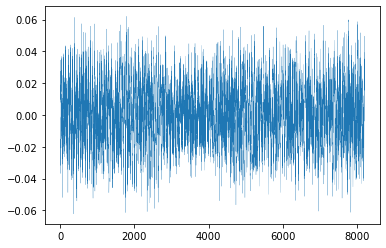

In [10]:
# .iloc[0] --> The "zeroth" recording
# [:-4] --> Not include last four values o: y_labels ... damage_location ... damage_level .... voltage_level
first = data_dict["Sensor1"].iloc[0][:-4].values
plt.plot(first, linewidth=0.2) 

extract_inf(data_dict["Sensor1"].iloc[0])


## Notes to myself
- LXX is the damage location. L00 is undamaged. We have L1C (at floor 1 location C), L3A (floor 3 location A) and L1C (both areas damaged).
- DXX is damage level. DB0: bolts were removed between bracket and plate. DBB: brackets were completely removed. DHT: left in at hand torque. DO5/D10 indicates torque level (5 or 10 ft Lbs)
- VXX: input level of the shaker (2,5,8 volts).
- Next 6 digits are the date (data collected in 2000) and the final digits are the set number.


# Comparison of Different Voltage levels

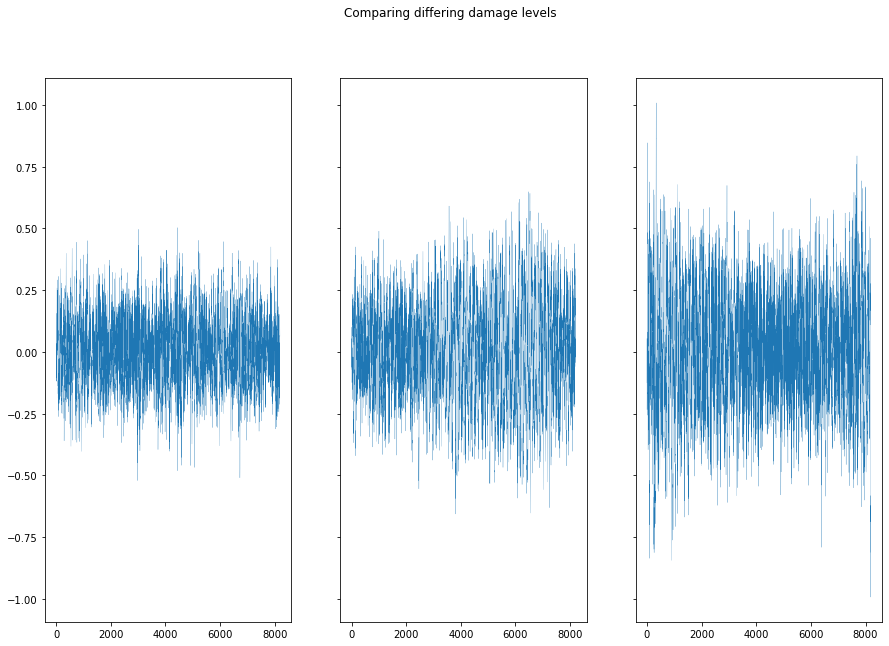

In [11]:
#find datapoints involving different kinds of voltages from sensor1
#DBB, voltage V02, V05, V08
sens1 = data_dict["Sensor1"]
ind = (sens1["damage_level"]=="DBB")
DBB_damaged = sens1[ind.squeeze(axis=1)]

DBB_V02 = DBB_damaged[(DBB_damaged["voltage_level"]=="V02").squeeze(axis=1)]
DBB_V05 = DBB_damaged[(DBB_damaged["voltage_level"]=="V05").squeeze(axis=1)]
DBB_V08 = DBB_damaged[(DBB_damaged["voltage_level"]=="V08").squeeze(axis=1)]

DBB_V02_0 = DBB_V02.iloc[0]
DBB_V05_0 = DBB_V05.iloc[0]
DBB_V08_0 = DBB_V08.iloc[0]

data_V02, _, _, _, _ = extract_inf(DBB_V02_0)
data_V05, _, _, _, _ = extract_inf(DBB_V05_0)
data_V08, _, _, _, _ = extract_inf(DBB_V08_0)

data_volt = [data_V02, data_V05, data_V08]
multiplot(data_volt)
plt.savefig("voltage_comparisons.png")


# V02, V05 seem almost exactly the same; V08 peaks higher?
# Hypothesis: higher voltage leads to higher variance and larger peaks in the data.
# It's possible that floor 3 experiences larger accelerations due to higher floor, so we could take a peek at that data as well
# Also, bigger differences in having 13 damaged?


neural for feature extractor
end-to-end?
probability distributions and comparing distributions with divergence scores? 
barycentre the distributions together?
barycentre data together?
...
variational mode decomposition

# Comparison of Different Damage Levels 

In [12]:
cases = [['L00','D00','V08'],   ['L1C','DB0','V08'],     ['L1C','DBB','V08'],      ['L13','DBB','V08']]
col_names = [["damage_location"], ["damage_level"], ["voltage_level"]]

sens1 = data_dict["Sensor1"] 

L00_D = [] #initialise lists for indicators, rows, then data
data_L00_D = []
ind_D = []
num_samples = 5 # number of segments you wish to extract from each type of data

for i in range(len(cases)):
    ind_D.append(sens1[col_names]==cases[i]) # turn the indicators into a single T/F and find corresponding rows
    L00_D.append(sens1[ind_D[i].apply(boolean_rows, axis=1)])
    data = L00_D[i].iloc[0:num_samples, :-4]
    data_L00_D.append(data)

ts_pre_cat = []
for j in range(len(cases)):
    temp_data = []
    for i in range(num_samples):
        temp_data.append(data_L00_D[j].iloc[i,:])
    ts_pre_cat.append(pd.concat(temp_data))
ts_cat = pd.concat(ts_pre_cat)

print(ts_cat)

Xt_0       0.068721
Xt_1       0.045065
Xt_2       0.072448
Xt_3       0.037730
Xt_4       0.045542
             ...   
Xt_8187   -0.464490
Xt_8188   -0.425560
Xt_8189   -0.459890
Xt_8190   -0.478010
Xt_8191   -0.253870
Length: 163840, dtype: float64


# Thoughts 
- Characterise damage by amount of variation from the mean? (obtain features from each series then feed into a neural network/log regressor?). We can do this if we split up the information from each sensor into 8192 blocks - may not be the idea of our work? (we want to detect a transition/change in behaviour, rather than just categorising 8192-long signal)
- Can we spot similar patterns when we concatenate these data points into one? (use matrix profile of size 8192?). If we did not know that each experiment was ~5 seconds long, how would we determine the approximate size of anomalous signals?


# Detect Transition with Matrix Profiles
In this section, the aim is to concatenate together homogeneous sensor information and use matrix profile to detect a "change" in behaviour of the time series. Highly experimental!

Motif length: 512. Motif located at 110003. Nearest neighbour: 110978
Potential discord/anomaly located at 129881 with distance 0.14318520055116646.
Motif length: 1024. Motif located at 109459. Nearest neighbour: 110126
Potential discord/anomaly located at 129724 with distance 0.21266039340472498.
Motif length: 2048. Motif located at 110872. Nearest neighbour: 110308
Potential discord/anomaly located at 129433 with distance 0.2855890558801477.
Motif length: 4096. Motif located at 109702. Nearest neighbour: 108625
Potential discord/anomaly located at 127335 with distance 0.34817067070512586.
Motif length: 8192. Motif located at 97687. Nearest neighbour: 108307
Potential discord/anomaly located at 137761 with distance 0.4636323687660812.


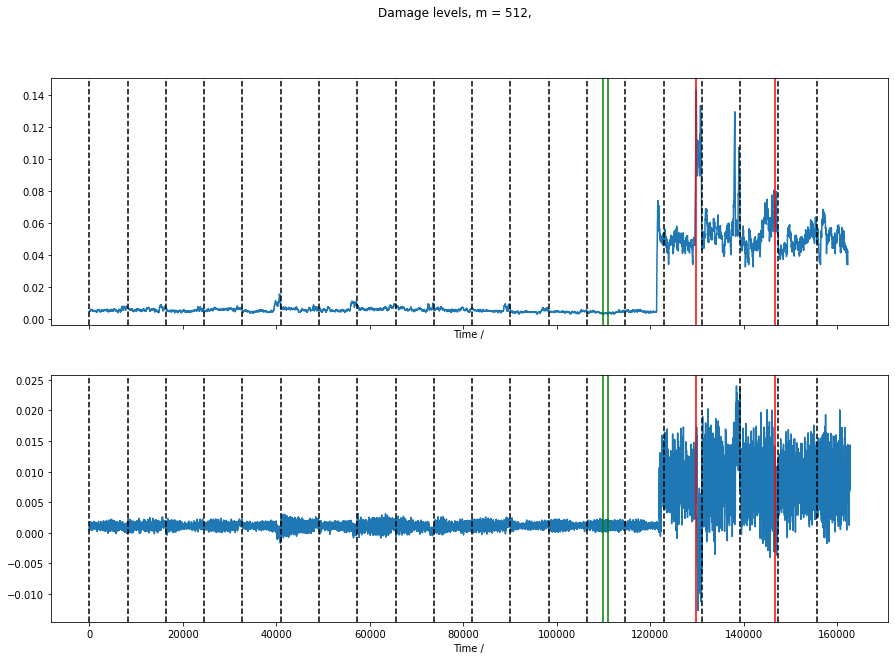

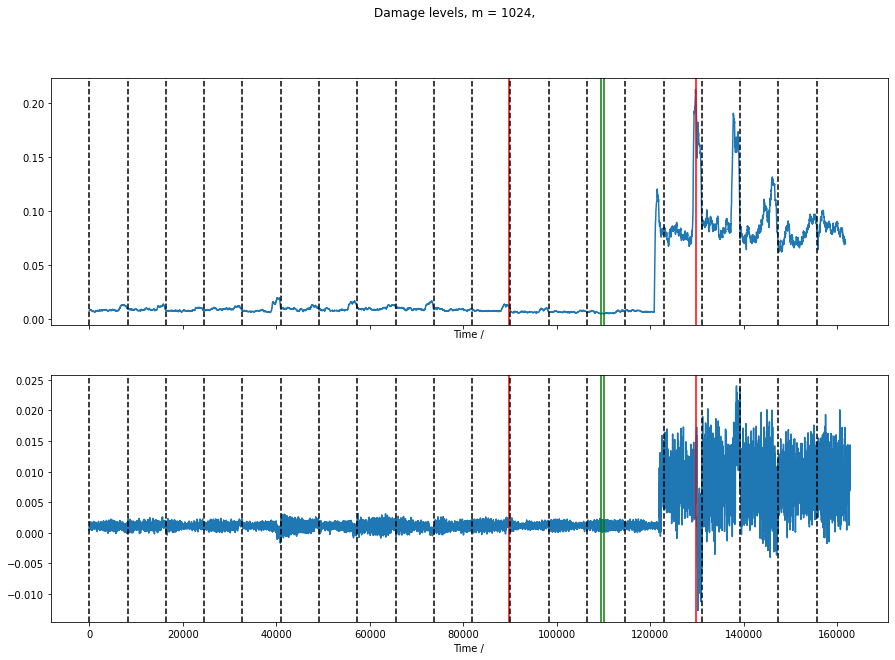

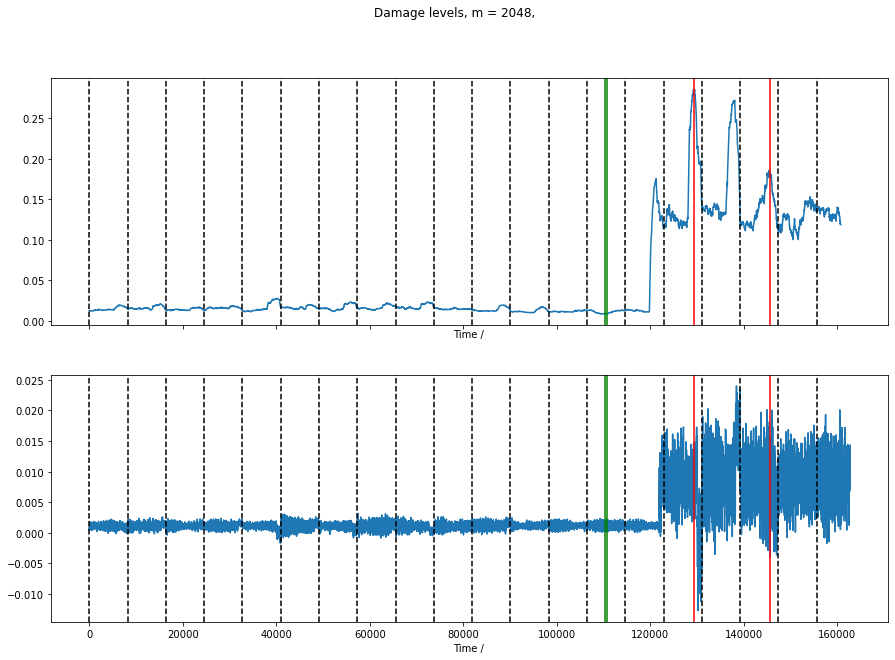

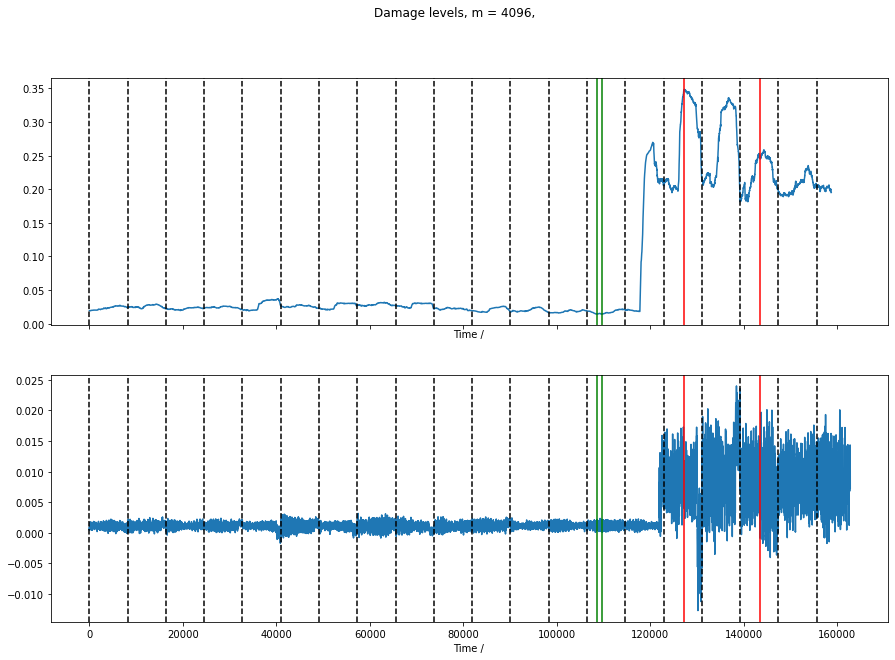

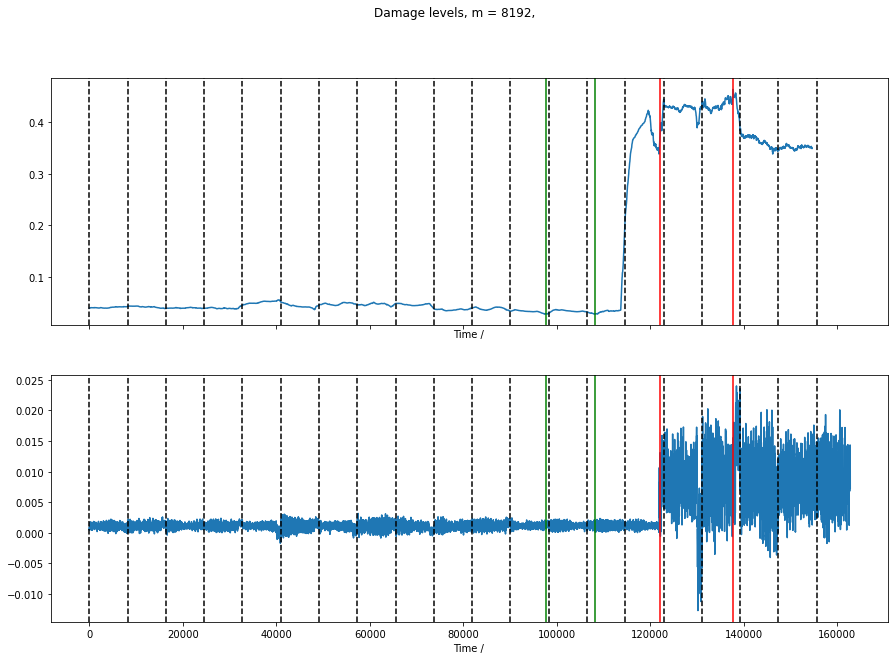

In [15]:
# there are 4 distinct transitions, each 8192 data points long. Can we detect the transition betweeen each damage type?

# remove z-normalisation
#smoothen
WINDOW = 10
ts_cat = ts_cat.rolling(window=WINDOW).mean().dropna()
mp_list = []
stump_length = [512, 1024, 2048, 4096, 8192]
for m in stump_length:
    mp = stumpy.stump(ts_cat.astype(float), m, normalize = False)
    mp_list.append(mp)
    
    #multiplot([pd.DataFrame(mp[:,0]), pd.DataFrame(ts_cat)], orientation="horizontal") just do this code manually

    mp_idx = np.argsort(mp[0:, 0])[0] #take the 0th columns first element
    nearest_neighbour_idx = mp[mp_idx, 1]
    print(f"Motif length: {m}. Motif located at {mp_idx}. Nearest neighbour: {nearest_neighbour_idx}")

    # discord 
    discord_idx = np.argsort(mp[:, 0])[-1] #maximum distance 
    discord_dist = mp[discord_idx, 0] #maximum distance
    discord2_idx = mp[discord_idx, 1] #nearest neighbour
    discord2_dist = mp[discord2_idx, 0]
    print(f"Potential discord/anomaly located at {discord_idx} with distance {discord_dist}.")

    fig, axs = plt.subplots(2,1, sharex=True)
    fig.suptitle(f"Damage levels, m = {m}, ")
    
    for id_x, data in enumerate([mp[:,0], ts_cat.values]):

        axs[id_x].plot(data)
        axs[id_x].set_xlabel("Time / ")
        axs[id_x].axvline(x=mp_idx, color="g")
        axs[id_x].axvline(x=nearest_neighbour_idx, color="g") #nearest neighbours (motif)
        axs[id_x].axvline(x=discord_idx, color="r") #red line: discord
        axs[id_x].axvline(x=discord2_idx, color="r") #nearest red neighbour

    #actual split points
    split = np.arange(0,len(ts_cat),8192)
    for x in split:
        axs[0].axvline(x=x, color="black", linestyle="dashed")
        axs[1].axvline(x=x, color="black", linestyle="dashed")
    

    fig.set_size_inches(15,10)


#yellow is actual split points, green is detected nearest neighbour, red is detected discord area

# X - mu / sigma , if X ~ N(mu, sigma^2), then X - mu / sigma ~ N(0,1)

# variational mode decomposition try out

Motif length: 512. Motif located at 120892. Nearest neighbour: 137366
Potential discord/anomaly located at 17102 with distance 20.201262564718697.
Motif length: 1024. Motif located at 31748. Nearest neighbour: 71730
Potential discord/anomaly located at 11715 with distance 30.254937032052588.
Motif length: 2048. Motif located at 46494. Nearest neighbour: 136636
Potential discord/anomaly located at 127229 with distance 42.09405701470181.
Motif length: 4096. Motif located at 39711. Nearest neighbour: 129782
Potential discord/anomaly located at 116913 with distance 60.92135185468443.
Motif length: 8192. Motif located at 39383. Nearest neighbour: 129456
Potential discord/anomaly located at 112813 with distance 96.76343487444194.


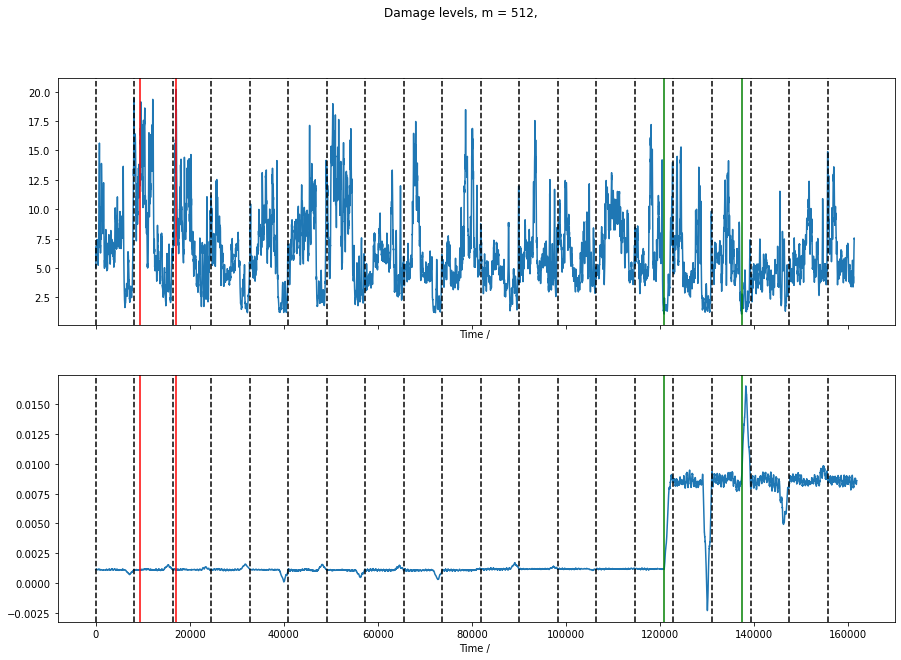

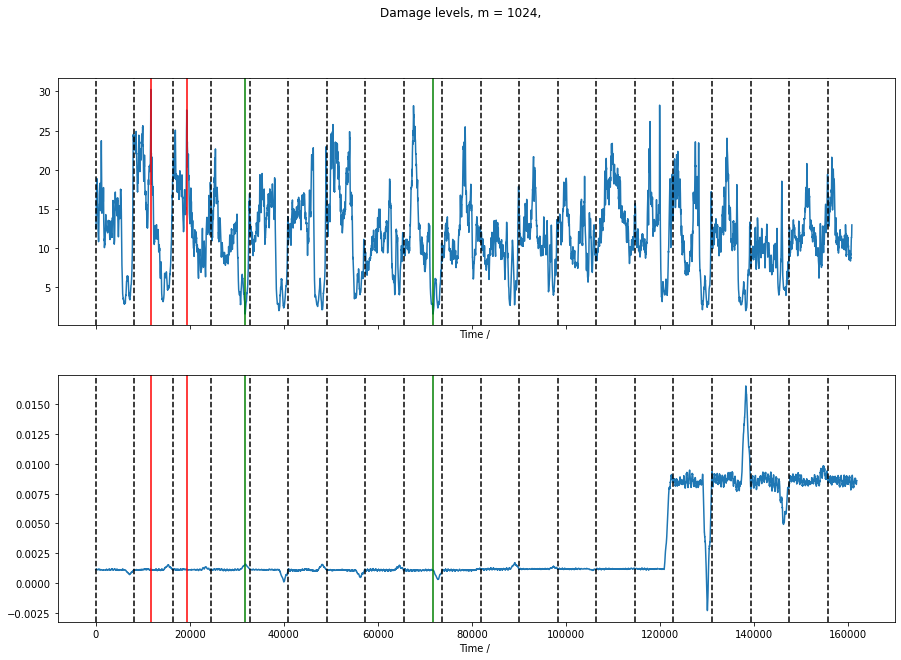

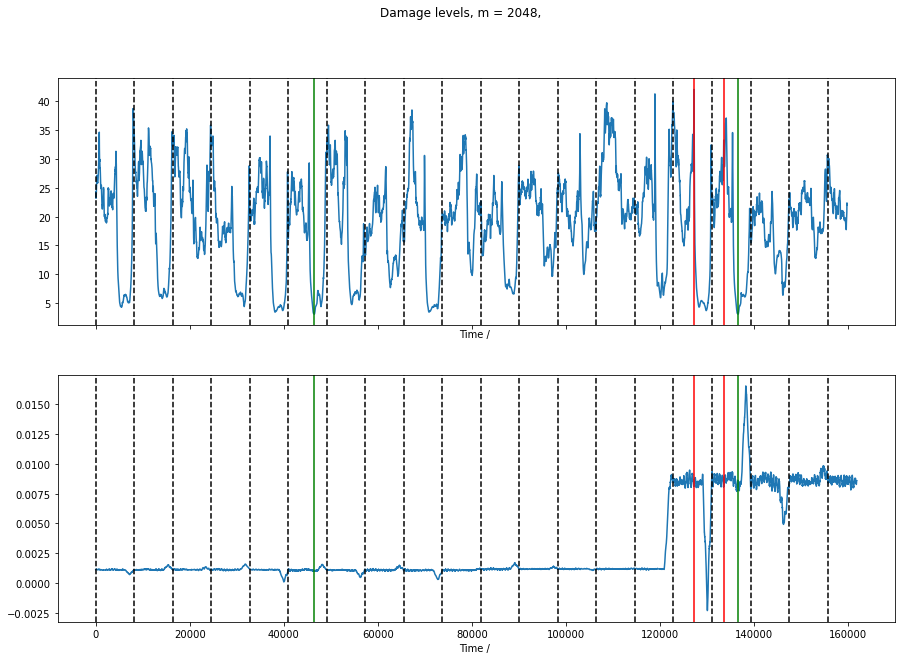

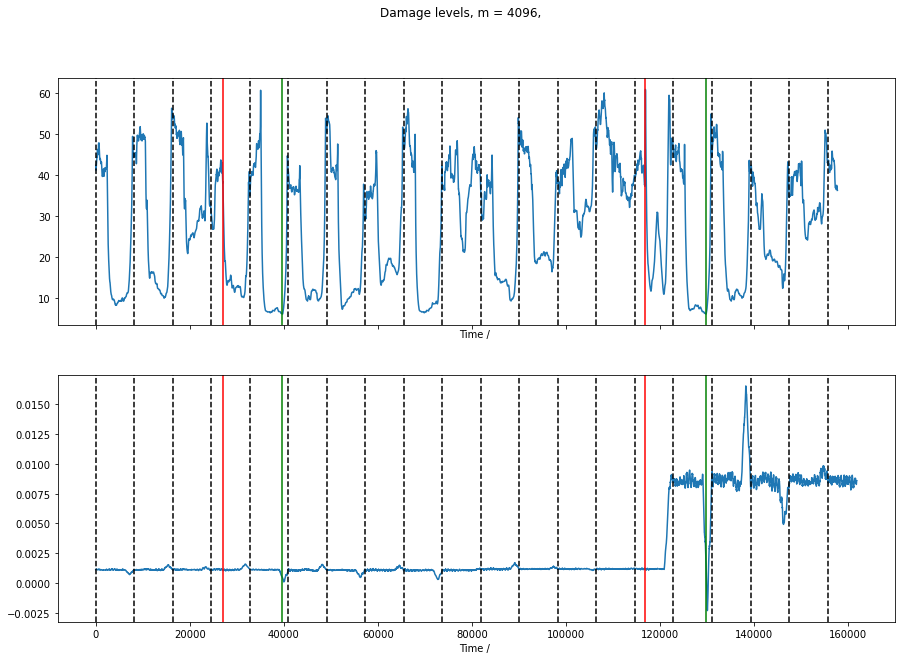

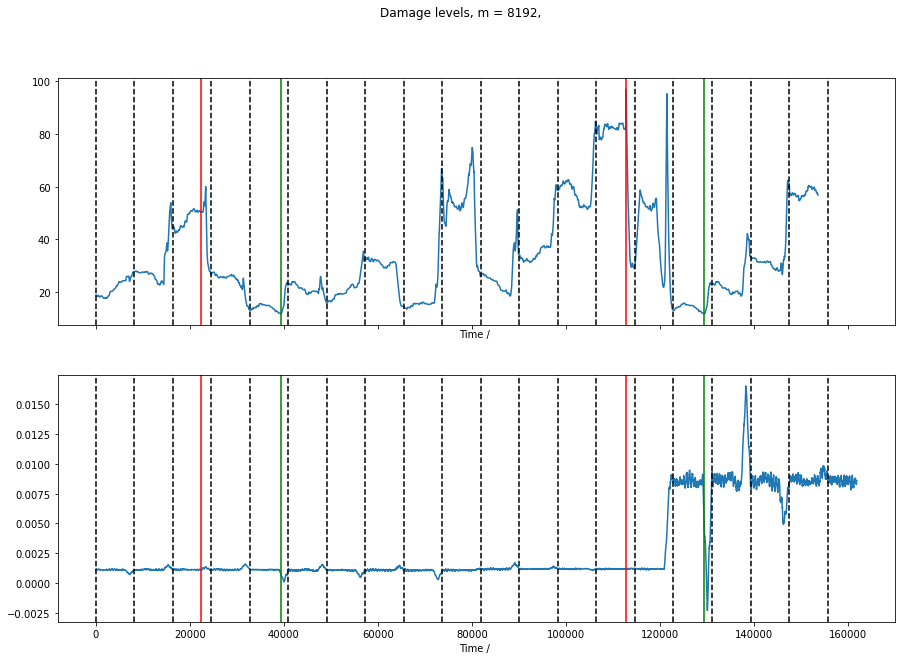

In [16]:
# Exact same code as above, but with z-normalisation again for comparison
# remove z-normalisation
#smoothen
ts_cat = ts_cat.rolling(window=WINDOW).mean().dropna()
mp_list_znorm = []
stump_length = [512, 1024, 2048, 4096, 8192]
for m in stump_length:
    mp = stumpy.stump(ts_cat.astype(float), m, normalize = True)
    mp_list_znorm.append(mp)
    
    #multiplot([pd.DataFrame(mp[:,0]), pd.DataFrame(ts_cat)], orientation="horizontal") just do this code manually

    mp_idx = np.argsort(mp[0:, 0])[0] #take the 0th columns first element
    nearest_neighbour_idx = mp[mp_idx, 1]
    print(f"Motif length: {m}. Motif located at {mp_idx}. Nearest neighbour: {nearest_neighbour_idx}")

    # discord 
    discord_idx = np.argsort(mp[:, 0])[-1] #maximum distance 
    discord_dist = mp[discord_idx, 0] #maximum distance
    discord2_idx = mp[discord_idx, 1] #nearest neighbour
    discord2_dist = mp[discord2_idx, 0]
    print(f"Potential discord/anomaly located at {discord_idx} with distance {discord_dist}.")

    fig, axs = plt.subplots(2,1, sharex=True)
    fig.suptitle(f"Damage levels, m = {m}, ")
    
    for id_x, data in enumerate([mp[:,0], ts_cat.values]):

        axs[id_x].plot(data)
        axs[id_x].set_xlabel("Time / ")
        axs[id_x].axvline(x=mp_idx, color="g")
        axs[id_x].axvline(x=nearest_neighbour_idx, color="g") #nearest neighbours (motif)
        axs[id_x].axvline(x=discord_idx, color="r") #red line: discord
        axs[id_x].axvline(x=discord2_idx, color="r") #nearest red neighbour

    #actual split points
    split = np.arange(0,len(ts_cat),8192)
    for x in split:
        axs[0].axvline(x=x, color="black", linestyle="dashed")
        axs[1].axvline(x=x, color="black", linestyle="dashed")
    

    fig.set_size_inches(15,10)


#yellow is actual split points, green is detected nearest neighbour, red is detected discord area

# X - mu / sigma , if X ~ N(mu, sigma^2), then X - mu / sigma ~ N(0,1)

# variational mode decomposition try out


The matrix profiles seem to return decent segmentations even on the uncleaned data. The red two red lines indicate the subsequences that are furthest from each other (after z-normalising)

In the next section, we will concatenate together a longer time series, convert it to the Fourier domain, cut off higher frequencies then smooth it before using the matrix profile.

In [17]:
np.shape(mp) # stumpy.stump returns: 
# 0. matrix profile values (z-normalised Euclidean distances) 
# 1. matrix profile indices
# 2.
# 3. 


(153651, 4)

In [18]:
freq_cut = 2000 #set a frequency cut off point
fft_cat = np.fft.fft(ts_cat)
abs_fft_cat = abs(fft_cat)
log_fft_cat = np.log(abs_fft_cat[0:freq_cut])

In [1]:
log_fft_cat

NameError: name 'log_fft_cat' is not defined

In [19]:
print(np.argsort(abs_fft_cat)[-10:])

[    10 161836      6 161839      3 161840      2 161841      1      0]


In [40]:
ts_cat

Xt_1998    0.001115
Xt_1999    0.001115
Xt_2000    0.001116
Xt_2001    0.001116
Xt_2002    0.001116
             ...   
Xt_8187    0.008607
Xt_8188    0.008609
Xt_8189    0.008610
Xt_8190    0.008611
Xt_8191    0.008610
Length: 161842, dtype: float64

Note: if you do argsort and check where the largest values of fft_cat are, we see that the largest frequencies still tend to appear around ~1000 points in, so to be safe, I took n = 2000.

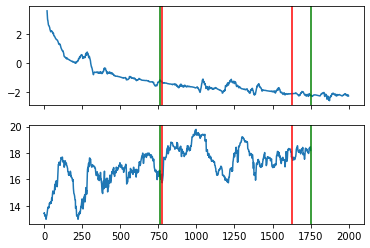

In [20]:
log_mp = stumpy.stump(log_fft_cat.astype(float), 250) #By eye, it seems some of the "peaks" are size ~250?
log_mp_val = log_mp[:,0]
# do another moving average perhaps 
log_fft_cat = pd.Series(log_fft_cat).rolling(20).mean().dropna()

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(log_fft_cat)
axs[1].plot(log_mp_val)
log_mp_idx = np.argsort(log_mp[:,-1])[0]
nearest_log_idx = log_mp[log_mp_idx, 1]
log_discord_idx = np.argsort(log_mp[:,-1])[-1]
log_discord2_idx = log_mp[log_discord_idx,1]

for i in [0,1]: #green lines are similar patterns, red are discords
    axs[i].axvline(x=log_mp_idx, color="g")
    axs[i].axvline(x=nearest_log_idx, color="g")
    axs[i].axvline(x=log_discord_idx, color="r")
    axs[i].axvline(x=log_discord2_idx, color="r")

# variational mode decomposition?

The matrix profile is a lot cleaner and shows clear peaks and troughs. But how do we interpret this? Hmm...

In [21]:
# Convert back to signal? Take exponential, then inverse fft


# Potential Extensions and Thoughts

- What if we concatenate more data together?
- Use FLUSS for semantic segmentation?
- Create a histogram of nearest neighbours and use this as a probability distribution?

# Categorise Data based on Simple Features
In this section, the aim is to categorise damage levels (possibly try voltage) when given a particular 8192-point sequence experiment.
- Idea: clear deviations in each time series can be detected in amplitude and total variance from the mean by eye. If we can compute several features for each time series, we can regress on these features to predict the damage level. This can clearly be done for Sensor 1, DBB13 versus the other damage levels, but it is much harder to do so between the other three damage levels.

Question: Can I predict healthy vs damaged? Can I predict damage levels?

In [22]:
# obtain samples of healthy and damaged cases for sensor 1
sens1 = data_dict["Sensor1"].copy() # this was previously defined for the voltage levels
voltage_levels = ["V02", "V05", "V08"]

for volt_levs in voltage_levels:
    sens1[volt_levs] = sens1["voltage_level"].transform(lambda a: a == volt_levs, axis = 0)
    sens1[volt_levs] = sens1[volt_levs].astype(int)

healthy_s1 = sens1[(sens1["y_labels"]==0).squeeze(axis=1)]
damaged_s1 = sens1[(sens1["y_labels"]==1).squeeze(axis=1)]

data_healthy_s1 = healthy_s1.iloc[:,0:-10]
data_damaged_s1 = damaged_s1.iloc[:,0:-10]


In [23]:
# Generate some useful features 

data_healthy_s1["mean"] = data_healthy_s1.apply(np.mean, axis=1)
data_healthy_s1["max"] = data_healthy_s1.apply(max, axis = 1)
data_healthy_s1["min"] = data_healthy_s1.apply(min, axis = 1)
data_healthy_s1["sum"] = data_healthy_s1.apply(np.linalg.norm, ord=1, axis = 1)


data_damaged_s1["mean"] = data_damaged_s1.apply(np.mean, axis=1)
data_damaged_s1["max"] = data_damaged_s1.apply(max, axis = 1)
data_damaged_s1["min"] = data_damaged_s1.apply(min, axis = 1)
data_damaged_s1["sum"] = data_damaged_s1.apply(np.linalg.norm, ord=1, axis = 1)


In [24]:
data_damaged_s1

,Xt_0,Xt_1,Xt_2,Xt_3,Xt_4,Xt_5,Xt_6,Xt_7,Xt_8,Xt_9,...,Xt_8183,Xt_8184,Xt_8185,Xt_8186,Xt_8187,Xt_8188,mean,max,min,sum
150,-0.192500,-0.204400,-0.169250,-0.377700,-0.192910,-0.167900,-0.382030,-0.178980,-0.24063,-0.329580,...,0.108960,0.010679,-0.060292,0.002028,-0.170200,-0.059886,0.005218,0.63536,-0.59224,1170.485984
151,-0.051640,-0.256580,-0.261710,-0.161680,-0.313080,-0.276850,-0.292400,-0.300110,-0.29700,-0.209260,...,0.092060,0.069078,0.173440,0.282940,0.256710,0.279020,0.005356,0.66537,-0.67848,1369.227086
152,-0.005542,0.106120,-0.002704,0.174790,0.138430,-0.033120,0.010950,0.154380,-0.13924,-0.055831,...,-0.124910,-0.034607,-0.149780,-0.230890,-0.130590,-0.172490,0.005447,0.59913,-0.65374,1273.812114
153,-0.270230,-0.125720,-0.121260,-0.219270,-0.149780,-0.046638,-0.113150,-0.017709,0.13708,-0.039609,...,-0.232650,-0.151950,-0.167360,-0.081650,-0.140050,-0.153840,0.005060,0.75040,-0.79123,1681.931753
154,0.112880,-0.144380,0.098954,0.108960,0.048531,0.103410,0.359180,0.131260,0.27091,0.341470,...,-0.443130,-0.406770,-0.616840,-0.373650,-0.384190,-0.518020,0.005162,0.64023,-0.68294,1311.221655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0.161270,0.318900,0.262800,0.016492,0.259690,-0.067862,-0.098819,0.036770,-0.26266,-0.161270,...,-0.172900,0.083543,-0.172630,0.025279,0.052992,-0.182770,0.008697,1.07090,-1.07670,1898.866217
266,-0.122610,-0.046097,-0.191960,-0.021089,-0.050964,-0.279290,-0.143700,-0.332550,-0.16438,0.047720,...,-0.002433,0.224540,0.270910,-0.129230,0.196690,0.207910,0.008777,0.81786,-0.74418,1528.594145
267,0.191690,-0.179790,0.096385,0.050018,0.077054,0.202370,0.115180,0.170740,0.30200,0.385680,...,0.399330,0.053532,0.028524,0.518700,-0.045286,0.190340,0.009400,1.01280,-1.01510,1690.163169
268,-0.340660,-0.090032,-0.384460,-0.381080,-0.109500,-0.296590,-0.268340,-0.148300,-0.32268,-0.021764,...,0.501660,0.223190,0.265630,0.454890,0.195470,0.147210,0.009480,1.07750,-1.04670,1925.395419


# Distribution and Autocorrelation of Healthy vs Damaged TS

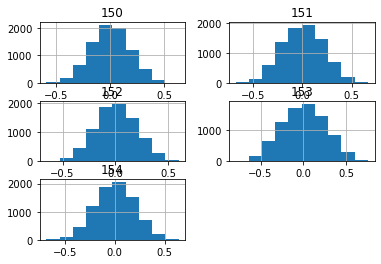

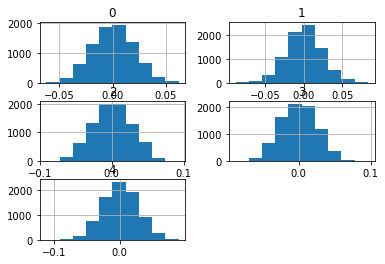

Text(0.5, 0.98, 'Autocorrelations at lag i, i = 0,...,n')

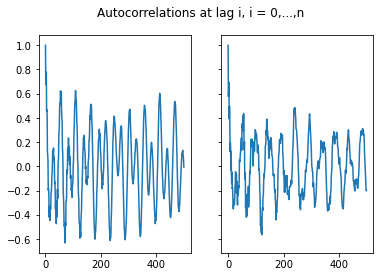

In [25]:
# histograms of the data points - normal distributions?
np.transpose(data_damaged_s1.iloc[:5,:-4]).hist(bins=10)
plt.show()
np.transpose(data_healthy_s1.iloc[:5,:-4]).hist(bins=10)
plt.show()

# use this if you want to autocorrelation a dataframe, otherwise just use autocorr
def df_autocorr(df, lag=1, axis=0):
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

damage_ac = []
healthy_ac = []

for i in range(500):
    damage_ac.append(data_damaged_s1.iloc[0,:-4].autocorr(lag=i))
    healthy_ac.append(data_healthy_s1.iloc[0,:-4].autocorr(lag=i))

fig, axs = plt.subplots(1,2,sharey=True)
axs[0].plot(damage_ac)
axs[1].plot(healthy_ac)
fig.suptitle("Autocorrelations at lag i, i = 0,...,n")


In [26]:
# Collect features together into one dataframe
# healthy features
min_max = ["mean", "max", "min", "sum"]
volts_y_labels = ["V02", "V05", "V08", "y_labels"]

health_features = data_healthy_s1[min_max]
volt_health_features = healthy_s1[volts_y_labels]
healthy_input = pd.concat([health_features, volt_health_features], axis=1)


# damaged features
damage_features = data_damaged_s1[min_max]
volt_damage_features = damaged_s1[volts_y_labels]
# combine 
damaged_input = pd.concat([damage_features, volt_damage_features], axis=1)


In [27]:
#check the inputs look okay. Time to feed this into a regressor/network!
damaged_input
healthy_input


,mean,max,min,sum,V02,V05,V08,y_labels
0,0.000661,0.062118,-0.062169,129.532221,1,0,0,0
1,0.000709,0.083459,-0.088275,148.788554,1,0,0,0
2,0.000706,0.093108,-0.091134,181.948816,1,0,0,0
3,0.000692,0.096359,-0.087645,167.750877,1,0,0,0
4,0.000663,0.088803,-0.111110,176.273627,1,0,0,0
...,...,...,...,...,...,...,...,...
145,0.008544,1.060200,-1.088200,1758.072215,0,0,1,0
146,0.008933,0.865310,-0.753640,1469.119414,0,0,1,0
147,0.009325,0.896260,-0.846790,1782.948560,0,0,1,0
148,0.008589,0.919920,-0.932490,1663.526177,0,0,1,0


In [28]:
complete_input = pd.concat([healthy_input, damaged_input], axis=0)
complete_input # put data together, if needed

,mean,max,min,sum,V02,V05,V08,y_labels
0,0.000661,0.062118,-0.062169,129.532221,1,0,0,0
1,0.000709,0.083459,-0.088275,148.788554,1,0,0,0
2,0.000706,0.093108,-0.091134,181.948816,1,0,0,0
3,0.000692,0.096359,-0.087645,167.750877,1,0,0,0
4,0.000663,0.088803,-0.111110,176.273627,1,0,0,0
...,...,...,...,...,...,...,...,...
265,0.008697,1.070900,-1.076700,1898.866217,0,0,1,1
266,0.008777,0.817860,-0.744180,1528.594145,0,0,1,1
267,0.009400,1.012800,-1.015100,1690.163169,0,0,1,1
268,0.009480,1.077500,-1.046700,1925.395419,0,0,1,1


In [29]:
features = ["mean", "max", "min", "sum", "V02", "V05", "V08"]
target = "y_labels"
# create train and test set
train_X, test_X, train_Y, test_Y = train_test_split(complete_input[features], complete_input[target])

In [30]:
test_Y

,y_labels
211,1
219,1
183,1
227,1
217,1
...,...
57,0
258,1
19,0
92,0


In [31]:
train_X

,mean,max,min,sum,V02,V05,V08
80,0.008858,0.712140,-0.641580,1283.422491,0,1,0
191,0.009292,0.791360,-0.796090,1578.635525,0,0,1
213,0.001108,0.112320,-0.117260,219.873763,0,0,1
236,0.009033,0.545190,-0.639960,981.269543,0,0,1
93,0.007939,0.899640,-0.860300,1653.988054,0,1,0
...,...,...,...,...,...,...,...
187,0.006665,0.610080,-0.570880,979.852762,0,0,1
200,0.000841,0.072107,-0.069912,136.855695,1,0,0
7,0.000729,0.109770,-0.113730,206.067879,1,0,0
10,0.004605,0.739590,-0.825700,1495.087127,1,0,0


In [32]:
# Just throw a network on it and see what happens
class linear_nn(tf.keras.Model):
    def __init__(self, n):
        super(linear_nn, self).__init__()
        self.dense1 = Dense(n, input_dim = 7, activation="relu")
        self.dense2 = Dense(n, input_dim = n, activation="relu")
        #self.dense3 = Dense(n, input_dim = n, activation="relu")

        self.out = Dense(1, activation = "sigmoid")
        self.dropout = Dropout(rate=0.5)
    
    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.out(x)
    
# uncomment if you want to test 
# model = linear_nn(300)
# model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.fit(train_X.values, train_Y.values, validation_data = (test_X.values, test_Y.values), epochs = 5000,verbose=0)

# vals_train, train_acc = model.evaluate(train_X.values, train_Y.values,verbose=0)
# vals_test, test_acc = model.evaluate(test_X.values, test_Y.values,verbose=0)
# print(f"Validation accuracies: train - {train_acc:.3f}, test - {test_acc:.3f}")


In [33]:
# Data info
samples = 8192   # Counts
sample_freq = 1600 # Hz
total_time = 8192 / 1600 # 5.12 seconds

# Putting some Probability in the Profile
AKA playing with histograms and FLUSS

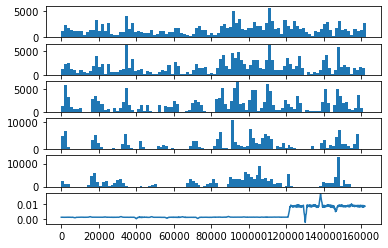

In [34]:
fig, axs = plt.subplots(len(stump_length)+1,1, sharex=True)
for i, length in enumerate(stump_length):
    axs[i].hist(mp_list[i][:,1], bins = 100) # 512; histograms of matrix profile indices (number of nearest neighbours...not so useful)
axs[5].plot(ts_cat.values)


# Under no effect, we might expect this distribution to be uniform over n?
# we could also consider the ARC distribution and compute some kind of divergence score
# extend more health and more damaged

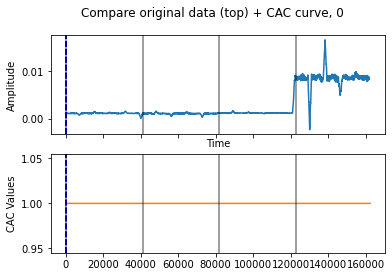

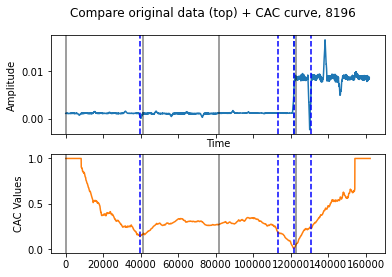

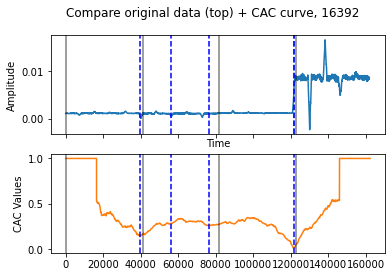

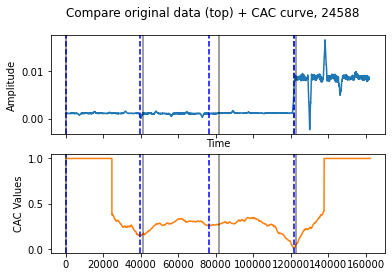

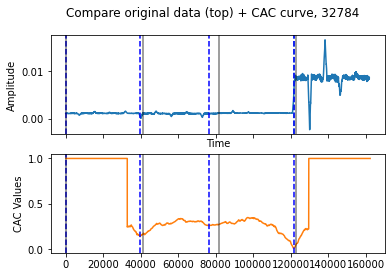

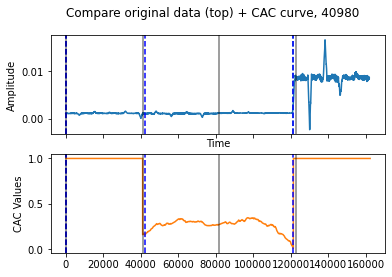

In [35]:
# flussing time 
# compute for non-z-normalised data; see below for z-normalised data
for L in [8196*n for n in range(6)] :
    cac, regime_locations = stumpy.fluss(mp_list[0][:,1], L=L, n_regimes=5, excl_factor=1)
    # plot cac and regime locations
    fig, axs = plt.subplots(2, sharex = True)
    fig.suptitle(f"Compare original data (top) + CAC curve, {L}")
    axs[0].plot(range(ts_cat.shape[0]), ts_cat)
    axs[0].axvline(x=regime_locations[0], linestyle="dashed")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Amplitude")
    axs[1].set_ylabel("CAC Values")
    axs[1].plot(range(cac.shape[0]), cac, color="C1")
    for reg in regime_locations:
        axs[0].axvline(x=reg, color="blue", linestyle="dashed")
        axs[1].axvline(x=reg, color="blue", linestyle="dashed")


    split = np.arange(0,len(ts_cat),num_samples * 8192)
    overlapping = 0.5
    for x in split:
        axs[0].axvline(x=x, color="black", linestyle="solid", alpha=overlapping)
        axs[1].axvline(x=x, color="black", linestyle="solid", alpha=overlapping) #yellow: theoretical damage sections; blue: computed regime changes

    plt.show()
    # why do we see normalised 1 values? Because AC > IAC; there appears to be many crossings on the edges; can I remove this?
    # very interesting to see the same segmentation occurring where I don't expect it to...?
    # exclusion factor? -> correction on left and right 

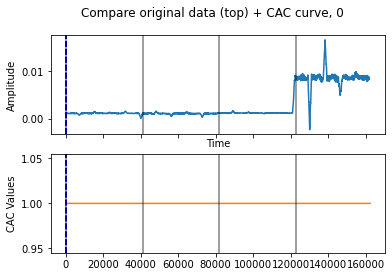

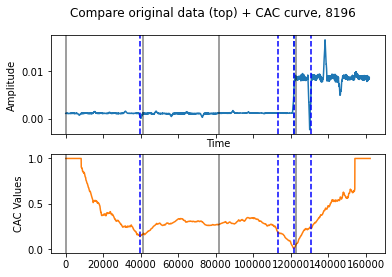

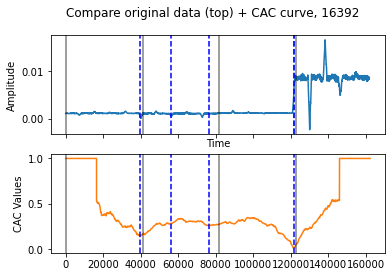

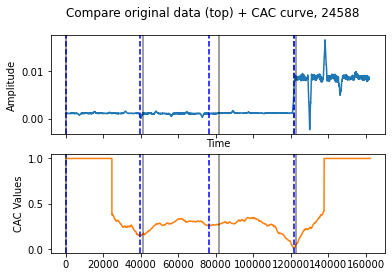

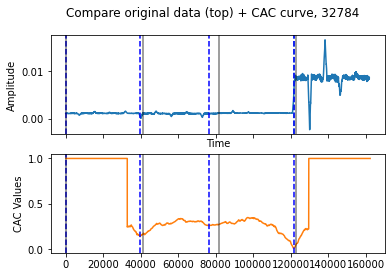

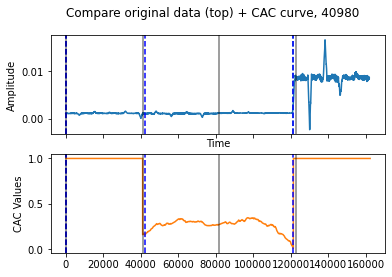

In [36]:
# flussing time 
# compute for z-normalised data
for L in [8196*n for n in range(6)] :
    cac, regime_locations = stumpy.fluss(mp_list[0][:,1], L=L, n_regimes=5, excl_factor=1)
    # plot cac and regime locations
    fig, axs = plt.subplots(2, sharex = True)
    fig.suptitle(f"Compare original data (top) + CAC curve, {L}")
    axs[0].plot(range(ts_cat.shape[0]), ts_cat)
    axs[0].axvline(x=regime_locations[0], linestyle="dashed")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Amplitude")
    axs[1].set_ylabel("CAC Values")
    axs[1].plot(range(cac.shape[0]), cac, color="C1")
    for reg in regime_locations:
        axs[0].axvline(x=reg, color="blue", linestyle="dashed")
        axs[1].axvline(x=reg, color="blue", linestyle="dashed")


    split = np.arange(0,len(ts_cat),num_samples * 8192)
    overlapping = 0.5
    for x in split:
        axs[0].axvline(x=x, color="black", linestyle="solid", alpha=overlapping)
        axs[1].axvline(x=x, color="black", linestyle="solid", alpha=overlapping) #yellow: theoretical damage sections; blue: computed regime changes

    plt.show()
    # why do we see normalised 1 values? Because AC > IAC; there appears to be many crossings on the edges; can I remove this?
    # very interesting to see the same segmentation occurring where I don't expect it to...?
    # exclusion factor? -> correction on left and right 

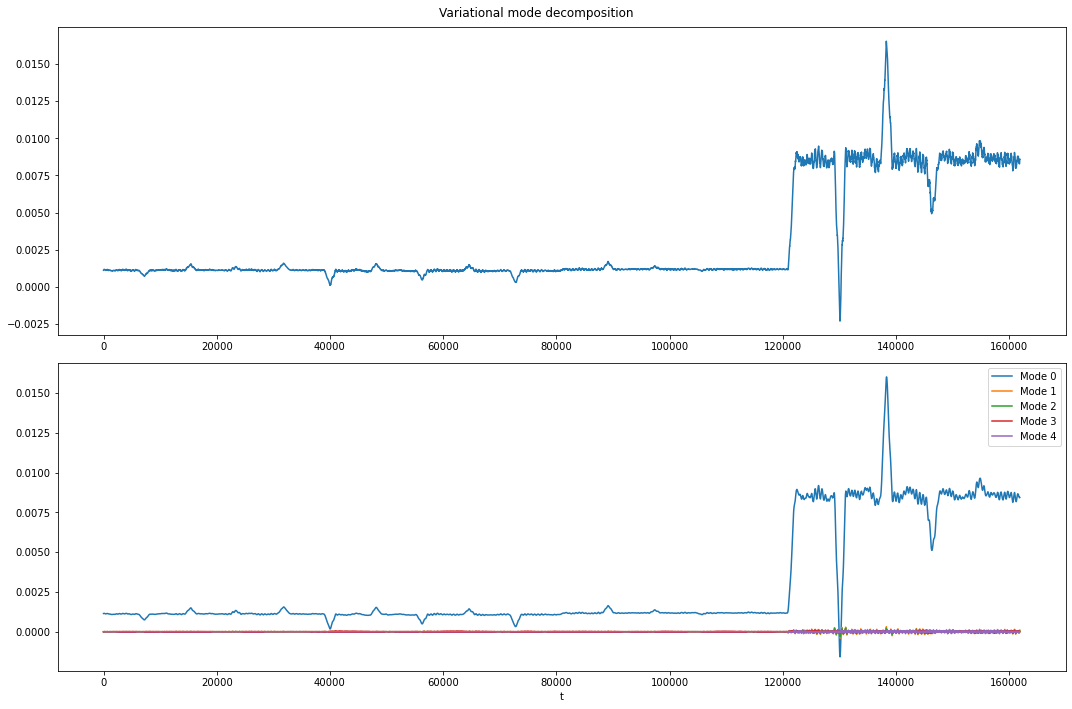

In [37]:
# attempts with variational mode decomposition 
# arbitrary initial parameters 
alpha = 2000
tau = 0.
k = 5
DC = 0
init = 1
tol = 1e-7
u, u_hat, omega = VMD(ts_cat, alpha, tau, k, DC, init, tol)

# check output 
fig, axs = plt.subplots(2,1)
fig.set_size_inches(15,10)
fig.suptitle("Variational mode decomposition")
axs[0].plot(ts_cat.values)
axs[1].plot(u.T)
axs[1].set_xlabel("t")
axs[1].legend(["Mode %d"%m_i for m_i in range(u.shape[0])])
plt.tight_layout()

# to do: understand the output of the variational mode decomposition (see paper), 
# and how to leverage this for damage processing (feature extraction like eeg paper?)


In [38]:
u

array([[ 1.14398542e-03,  1.14399235e-03,  1.14400318e-03, ...,
         8.44617682e-03,  8.44619606e-03,  8.44619454e-03],
       [-1.97130548e-05, -1.96955086e-05, -1.96635802e-05, ...,
         9.91056497e-05,  9.94232006e-05,  9.95704997e-05],
       [-7.55625281e-06, -7.54802000e-06, -7.53466746e-06, ...,
         3.97354611e-05,  3.98801058e-05,  3.99410150e-05],
       [-1.45259205e-06, -1.41449912e-06, -1.34285729e-06, ...,
         1.38696207e-05,  1.37848469e-05,  1.37273270e-05],
       [ 5.95468192e-08,  7.07202410e-08,  8.74403729e-08, ...,
         9.13883600e-06,  9.66765244e-06,  9.91875188e-06]])

# Proposed Task(s)

Consider the following cases, from no damage to steadily building up damage across structure. Do you feel it is possible to:

 1. Can you distinguish between **different** damage cases?
 2. Is it possible to localize or **"characterize"** this damage?
 3. Is there any difference between voltages? (I personally couldn't find much).
 4. Split up notebook into constituent parts and do data processing in another section.

 
Ultimately please choose your own task, as you see fit. The idea is to get "first hand experience" with some kind of real data, and then to describe your thought process, coding choices, or mathematical choices. : )



In [39]:
# FOR EXAMPLE: You can consider the following cases:

#       No Damage                # Mild damage @ L1C     # Large damage @ L1C      # Large damage @ L1C AND L3A
cases = [['L00','D00','V08'],   ['L1C','DB0','V08'],     ['L1C','DBB','V08'],      ['L13','DBB','V08']]

## Current(ish) Approach:

 1. *Matrix Profile:* Try to clean signal. Try to convert signal to Fourier domain (for example), or Wavelet domain or anything else in mind (feature engineering task)
 
 https://stumpy.readthedocs.io/en/latest/index.html
 
 
 2. *Semantic Segmentation:* Use matrix profile to find transitions in underlying signal
 
 https://stumpy.readthedocs.io/en/latest/Tutorial_Semantic_Segmentation.html
 
 3. *Information Combination:* Try to "combine" information from multiple sensors (there are 24 in total), by a barycentre approach (in particular Wasserstein barycentre)

 https://pythonot.github.io/auto_examples/unbalanced-partial/plot_UOT_barycenter_1D.html


 #### Note(s):
 
 
 When cleaning signal, consider something simple like moving average to remove noise.
 
 *If* you chose to use matrix profile, remember it likes "repetitive looking features". It characterises new events by seeing how different these "repetitive looking features" start to change.
 
 Notice that the current approach is not very probabilistic...
 
 Feature engineering of time series signals *can* be difficult. I don't believe it is possible to (convincingly) solve current problem with transforming or modifying the signals some way